# Algoritmos de detección de comunidades

En este cuaderno, se resolverá el [TPC04 - Comunidades](https://drive.google.com/file/d/1Y2JZm1qU4wPx8hfExzn9kQaQWFDB2ngB/view). En el mismo se podrán leer los resultados de los ejercicios, el código implementado para la resolución y comentarios sobre las tareas realizadas.

[Aquí un enlace para descargar los datos](http://materias.df.uba.ar/scytda2020c1/files/2020/04/TC04_ComunidadesData.zip). Para poder ejecutar el archivo, deben estar subidos al directorio del cuaderno donde se lo abre para poder cargarlo. 

Importamos librerías generales a utilizar.

In [79]:
import networkx as nx # Para redes en general
import community as community_louvain 
import igraph as ig 
import matplotlib.pylab as plt # Para graficar 
import matplotlib.cm as cm # para mapas de colores
import numpy as np
import cairo 
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score as info_mutua #ejercicio 1c
from itertools import combinations #combinaciones 
from collections import defaultdict #crear diccionarios sin KeyError
import scipy.stats as stats #Método Fisher Ejercicio 1d

# Ejercicio 1

## Inciso (a)

la partición en comunidades de esta red utilizando la metodología Louvain, infomap,
fast_greedy y edge_betweenness. Visualice los resultados gráficamente.

Cargamos la red de delfines y la definimos también en iGraph.

In [16]:
Red_delfines = nx.read_gml('./data/dolphins.gml')
posiciones = nx.kamada_kawai_layout(Red_delfines)

Red_delfines_igraph = ig.Graph.TupleList(Red_delfines.edges(), directed=False)

Hacemos un diccionario con los géneros guardados en el archivo .txt

In [8]:
def gend_dict(filename):      
    g_dict = {}
    with open(filename) as f:
        for line in f:
            data = line.strip().split()
            key = data[0]
            data = data[1]
            g_dict[key] = data

    return g_dict

gender_dict = gend_dict('./data/dolphinsGender.txt')

Codificamos el género con una "shape" a ser graficada. 

In [18]:
shape_dict = {}
for nodo in Red_delfines.nodes(): 
    if gender_dict[nodo] == 'm':
        shape_dict[nodo] = 's' 
    if gender_dict[nodo] == 'f':
        shape_dict[nodo] = '*' 
    if gender_dict[nodo] == 'NA':
        shape_dict[nodo] = '^'
nx.set_node_attributes(Red_delfines, shape_dict, 'shape')

shapes = set([nodo[1]['shape'] for nodo in Red_delfines.nodes(data = True)])

Para tener todo en el mismo formato necesitamos convertir las redes de iGraph a diccionario.

In [ ]:
# función que toma la Red de igraph y la partición calculada con Igraph, y la devuelve como diccionario
def convertir_particion_igraph_a_diccionario(Red_igraph,particion_igraph):
    particion_dict = {}
    for cluster in range(len(particion_igraph)):
        for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
            particion_dict.update({nodo:cluster})
    return particion_dict

def convertir_dict_a_lista(dict):
    categoria = set(dict.values())
    particiones = []
    for n in categoria:
        cluster = [k for k in dict.keys() if dict[k] == n]
        particiones.append(cluster)
    return particiones_louvline

Para graficar vamos a elegir colores para cada comunidad. 

In [19]:
#devuelve una lista de n colores hex
import random
def colores_hex(n):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(n)]
    return color

Creamos funciones para calcular las particiones. Edge Betweenness e Infomap requieren pasarlas a iGraph.

In [90]:
# devuelve particiones con Edge Betweenness
def edge_betweenness(Red): 
    Red_igraph = ig.Graph.TupleList(Red.edges(), directed=False) #la paso a igraph
    dendograma_edge_betweenness = Red_igraph.community_edge_betweenness(directed=False, weights=None)
    particiones_edge_betweenness = dendograma_edge_betweenness.as_clustering()
    dict_particiones_edge_betweenness = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_edge_betweenness)
    return dict_particiones_edge_betweenness

#devuelve particiones con Fast Greedy
def fast_greedy(Red):
    Red_igraph = ig.Graph.TupleList(Red.edges(), directed=False) #la paso a igraph
    dendograma_fast_greedy = Red_igraph.community_fastgreedy(weights=None)
    particiones_fast_greedy = dendograma_fast_greedy.as_clustering()
    dict_particiones_fast_greedy = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_fast_greedy)
    return dict_particiones_fast_greedy

#particiones con Louvline
def louvile(Red):
    dict_particiones_louvline = community_louvain.best_partition(Red)
    return dict_particiones_louvline


#particiones con infomap
def infomap(Red):
    Red_igraph = ig.Graph.TupleList(Red.edges(), directed=False) #la paso a igraph
    particiones_infomap = Red_igraph.community_infomap()
    dict_particiones_infomap = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_infomap)
    return dict_particiones_infomap

Calculamos las particiones y las guardamos en un diccionario.

In [91]:
particiones = {}
particiones['Edge_bet'] = edge_betweenness(Red_delfines)
particiones['Fast_greedy'] = fast_greedy(Red_delfines)
particiones['Louvline'] = louvile(Red_delfines)
particiones['Infomap'] = infomap(Red_delfines)

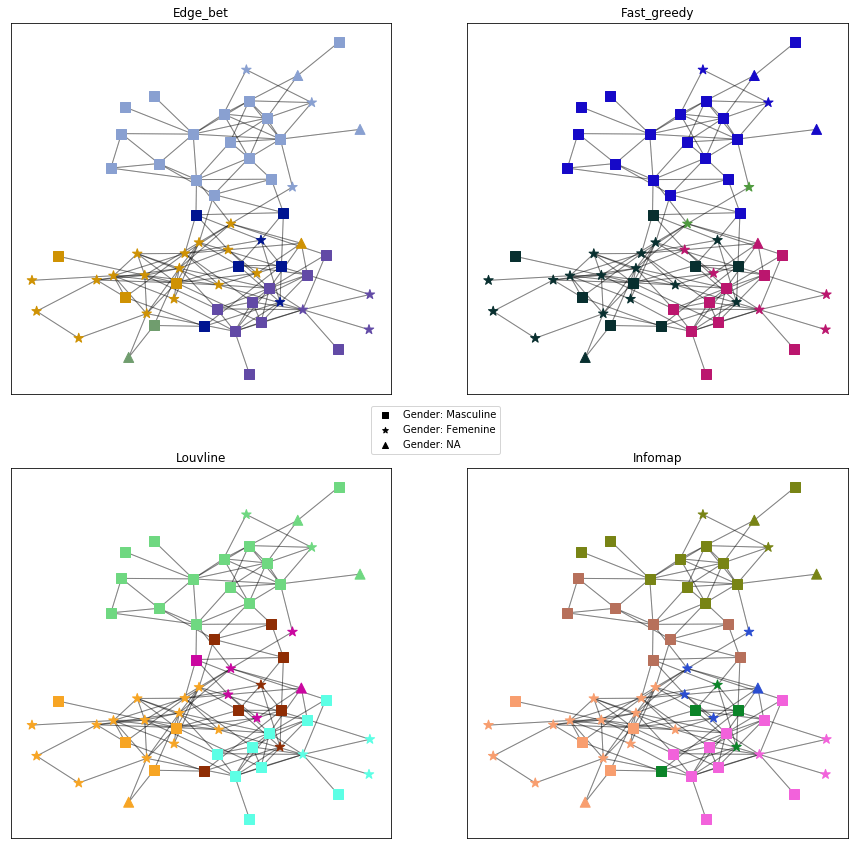

In [123]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,metodo in enumerate(particiones):
    particion = particiones[metodo]
    colores = colores_hex(max(particion.values())+1) #funcion que devuelve n colores

    node_color_dict = {}
    for node in Red_delfines.nodes():
        node_color_dict[node] = colores[particion[node]]
            
    for aShape in shapes: 
        
        node_list = [sNode for sNode, attr in Red_delfines.nodes(data = True) if attr['shape'] == aShape]
        node_color = [node_color_dict[sNode] for sNode in node_list]
        #nx.draw(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_nodes(Red_delfines,node_size= 100, ax = axs[i], node_color=node_color,pos=posiciones,node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_edges(Red_delfines, ax = axs[i], width=1.0, alpha=0.2,pos=posiciones)
    axs[i].set_title(metodo)
    
    label = {'s': 'Masculine', '*':'Femenine', '^':"NA"}
for aShape in shapes:
    plt.scatter([],[], c = 'black', marker = aShape, label='Gender: {}'.format(label[aShape]))

plt.legend(bbox_to_anchor=(0.1, 1.18))
plt.show()

A las particiones según cada método le agregamos forma a cada nodo según su género. 

## Inciso (b)
La modularidad es un escalar que se define como la diferencia entre la cantidad de enlaces que unen nodos de la misma clase para una red dada, y la cantidad esperada de dichos enlaces en una red aleatoria con la misma distribución de grado. De esta manera, valores positivos de la modularidad indican que existe clustering entre los nodos pertenecientes a una misma clase en la red, mientras que valores negativos indican la situación contraria.

Es importante notar que los algoritmos utilizados en el inciso anterior se basan en elegir una clasifcación que maximice la modularidad, partiendo de una red que no posee clasificación alguna. Es por ello que, por construcción, todas las particiones obtenidas a partir de dicho proceso tendrán modularidad positiva.

En la siguiente tabla se muestran los valores obtenidos para la modularidad Q

In [34]:
Coeficientes = {}
for i,metodo in enumerate(particiones):
    particion = particiones[metodo]
    mod = community_louvain.modularity(particion,Red_delfines)
    Coeficientes[metodo] = {}
    Coeficientes[metodo]['Modularidad'] = mod

df_modularidad = pd.DataFrame(Coeficientes)
df_modularidad.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Modularidad,0.519,0.492,0.519,0.525


Otra cantidad que permite medir el grado de agrupamiento en comunidades de una red
es el coeficiente de silouhette, que cuantifica la diferencia entre la distancia mínima de un nodo dado a un
nodo de una comunidad distinta a la suya y la distancia media de dicho nodo al resto de los
nodos de su comunidad.  

In [37]:
def Silhouette(Red,particion): # La función nos pide la Red y la partición como diccionario
    S=[]
    limites=[0]
  
    # Recorro los clusters sin repetir
    for cluster in set(particion.values()): 
    #Filtro los nodos que pertenecen a este cluster
        nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
        S_cluster=[]
    # Recorro los nodos del cluster
        for nodo in nodos_en_cluster:
            distancias_dentro=[]
            distancias_fuera=[]
            
            # Recorro los nodos del mismo cluster
            for nodo_en_cluster in nodos_en_cluster:
                if nodo != nodo_en_cluster:
                  # Calculo y guardo la distancia, si no es consigo mismo
                  distancias_dentro.append(nx.shortest_path_length(Red, source=nodo, target=nodo_en_cluster, weight=None))
            
            # Recorro los nodos de los otros clusters
            for nodo_fuera in Red.nodes():
                if particion[nodo_fuera] != cluster:
                  # Calculo y guardo la distancia
                  distancias_fuera.append(nx.shortest_path_length(Red, source=nodo, target=nodo_fuera, weight=None)) 
            
            # Calculo la distancia media para los del mismo cluster
            if distancias_dentro == []:
                distancia_media_dentro = 0
            else:
                distancia_media_dentro=np.mean(distancias_dentro)
             # Calculo la distancia mínima para los nodos fuera del cluster
            if distancias_fuera == []:
                distancia_min_fuera = 0
            else:
                distancia_min_fuera=np.min(distancias_fuera)
                
            # Calculo y guardo la Silhouette del nodo
            S_cluster.append((distancia_min_fuera-distancia_media_dentro)/np.max([distancia_min_fuera,distancia_media_dentro]))
        
        # Ordeno las Silhouette del mismo cluster por valor, para graficar lindo
        S_cluster=sorted(S_cluster)
        # Me guardo en qué nodo termina cada cluster, para graficar clusters por colores
        limites.append(len(S_cluster)+limites[-1])
        # Agrego las Silhouette de este cluster a la lista de todas
        S = S + S_cluster
        # Calculo la Silhouette media
    S_media = np.mean(S)

    return S,S_media,limites

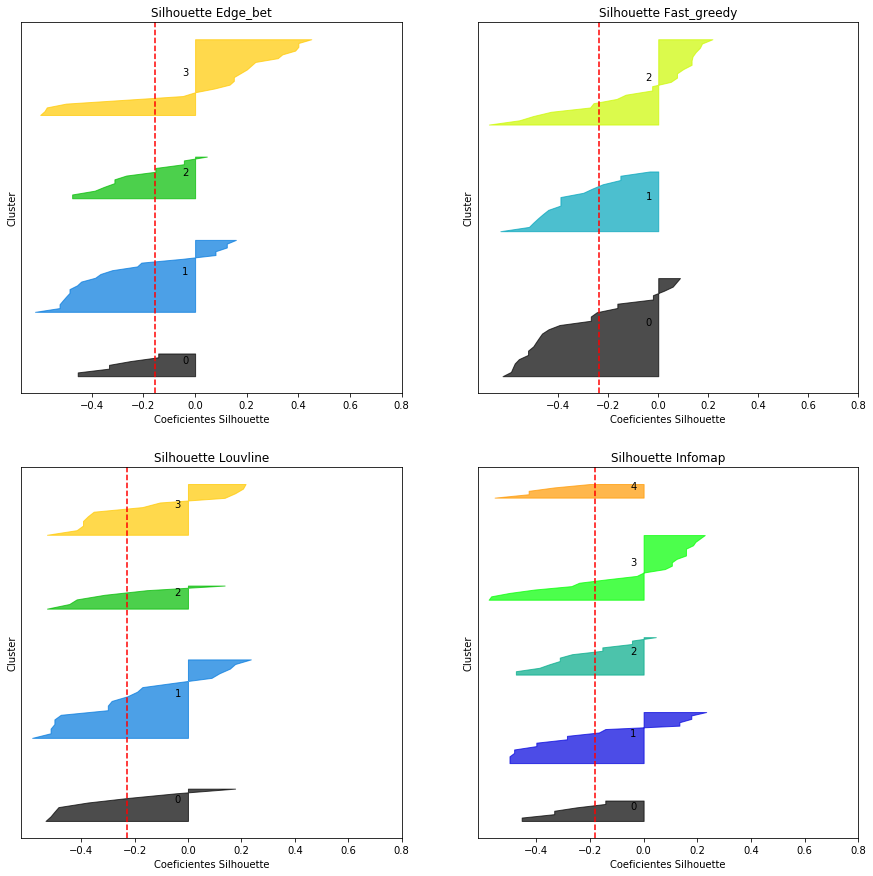

In [40]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for n,metodo in enumerate(particiones):
    particion = particiones[metodo]
    sample_silhouette_values,silhouette_avg,limites = Silhouette(Red_delfines,particion)
    Coeficientes[metodo]['Silhouette'] = silhouette_avg
    y_lower = 10
    n_clusters = max(particion.values())
    for i in range(n_clusters):
        # agrego los Silhouette values de las muestras del cluster i y los ordeno
        values = list(particion.values())
        ith_cluster_silhouette_values = [s_val for j, s_val in enumerate(sample_silhouette_values) if values[j] == i] 
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(ith_cluster_silhouette_values) #.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # pongo el label del cluster en la mitad del cluster 
        axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # reseteo el lower segun el nuevo upper
        y_lower = y_upper + 10  # 10 for the 0 samples

    axs[n].set_title(f"Silhouette {metodo}")
    axs[n].set_xlabel("Coeficientes Silhouette")
    axs[n].set_ylabel("Cluster")
    axs[n].axvline(x=silhouette_avg, color="red", linestyle="--") #linea que marca el silhouette score medio

    axs[n].set_yticks([]) 
    axs[n].set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8])

Resulta importante contar con una herramienta que
permita discernir si estos métodos de clasificación establecida denotan realmente la existencia de comunidades
en la red o si, por el contrario, el algoritmo forzó una clasificación "espuria" que no se condice
con la naturaleza de las interacciones sociales representadas por la red original. Una manera de
decidir esto es aplicar los mismos algoritmos a redes con la misma distribución de grado pero
recableadas al azar: si la clasifcación obtenida para la red original fue espuria, esperamos que,
partiendo de las redes recableadas al azar, el algoritmo continue convergiendo, en promedio, a
un valor similar de la modularidad (es decir, cualquier red con la misma distribución de grado se
puede clasificar de manera tal que se alcance dicho valor de la modularidad, independientemente
de la naturaleza de la red); si esto no sucede, es razonable aventurar que la clasificación obtenida
para la red original contiene información real sobre las interacciones entre los delfines y no fue
una simple consecuencia de la distribución de grados de la misma.

Para encontrar los nuevos valores de Modularidad se utilizan recableados con las particiones originales. De esta forma se mantiene firme la noción original de dichas particiones.
En el caso de Silhouette esto no es posible por la definición de susodicho coeficiente. Por esta misma razón se calculan nuevas particiones para cada recableo. Los recableos se realizan manteniendo el grado y al grafo conectado, intentando que replique la red original lo más fielmente posible y así darle al método de clasificación mayor confianza.

In [43]:
array_funciones = [edge_betweenness,fast_greedy,louvile,infomap]

#el recableo me devuelve un grafo conectado (1 sola componente)
def recableado(red): 
    Red = red.copy()
    enlaces_originales = Red.edges()
    e1 = [x[1] for x in enlaces_originales]
    e2 = [x[0] for x in enlaces_originales]
    random.shuffle(e2) #los reacomodo de una manera arbitraria
    enlaces_nuevos = list(zip(e1,e2))
        
    #creo una red nueva 
    Red_recableada=nx.Graph()
    lista_nodos = Red.nodes()
    lista_enlaces = enlaces_nuevos
    Red_recableada.add_nodes_from(lista_nodos)
    Red_recableada.add_edges_from(lista_enlaces)
    Red_recableada = nx.double_edge_swap(Red, nswap=50, max_tries=100)
    subgrafos = list((Red_recableada.subgraph(c) for c in nx.connected_components(Red_recableada)))
    while len(subgrafos) != 1: #si no es un grafo conectado, qrecablea
        Red_recableada = nx.double_edge_swap(Red, nswap=50, max_tries=100)
        subgrafos = list((Red_recableada.subgraph(c) for c in nx.connected_components(Red_recableada)))

    return Red_recableada
  

#Esta funcion devuelve dos listas con los valores de silhouette medio y modularidad de n recableados aleatorios
def silhouette_modularidad_random(Red,num_recableos,array_funciones,n_metodo,particion_original):
    nodos = Red.nodes()
    cant_nodos = len(nodos)
    lista_media_silhouette = []
    lista_valores_modularidad = []
    
    for i in range(num_recableos): #la recableamos n veces
        Red = Red.copy()
        Red_recableada = recableado(Red)
        particion_red_recableada = array_funciones[n_metodo](Red_recableada)
        silhouette_values,silhouette_media,limites = Silhouette(Red_recableada,particion_red_recableada) #valor medio de silhouette
        modularidad = community_louvain.modularity(particion_original,Red_recableada) # valor de modularidad

        lista_media_silhouette.append(silhouette_media)
        lista_valores_modularidad.append(modularidad)
   
    return lista_media_silhouette,lista_valores_modularidad

En el siguiente código visualizamos los histogramas con la distribucion de valores de Modularidad y Silhouette realizado con 100 recableados para cada metodo. Lo comparamos con el valor real de la red.

In [47]:
df_modularidad = pd.DataFrame(Coeficientes)
df_modularidad.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Modularidad,0.519,0.492,0.519,0.525
Silhouette,-0.154,-0.236,-0.229,-0.182


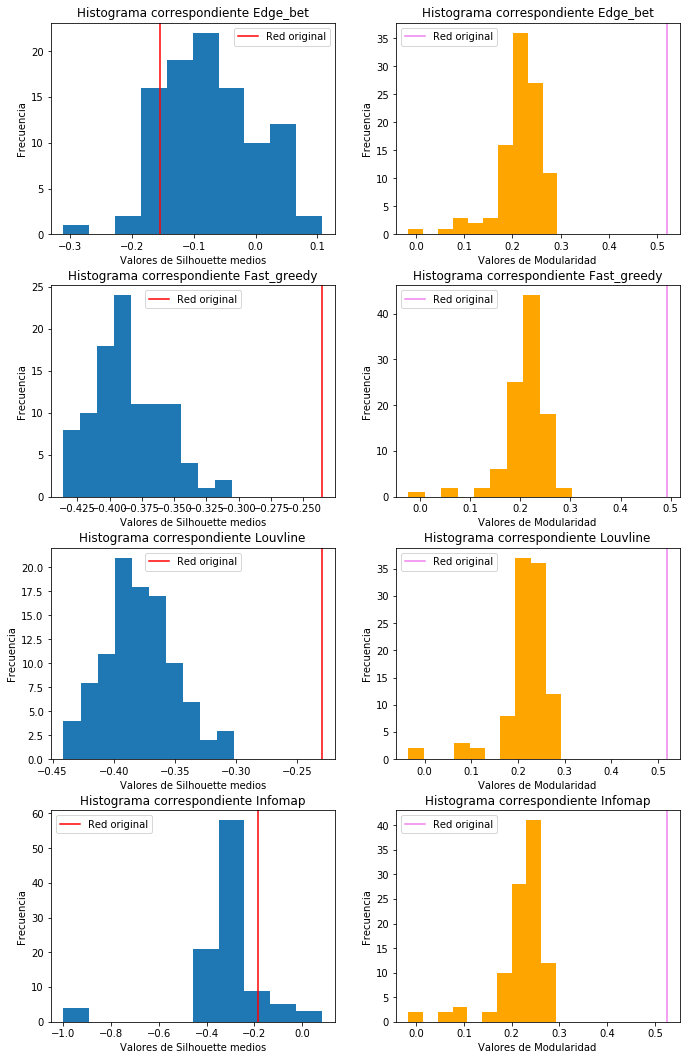

In [48]:
f, axs = plt.subplots(4, 2, figsize=(10,15))
f. tight_layout(pad=3.0)
for n,metodo in enumerate(particiones):
    particion = particiones[metodo]
    lista_media_silhouette,lista_valores_modularidad= silhouette_modularidad_random(Red_delfines,100,array_funciones,n,particion)

    #grafico Silhouette
    axs[n][0].hist(lista_media_silhouette)
    axs[n][0].set_xlabel('Valores de Silhouette medios')
    axs[n][0].set_ylabel('Frecuencia')
    axs[n][0].set_title(f'Histograma correspondiente {metodo}')
    axs[n][0].axvline(Coeficientes[metodo]['Silhouette'], label = 'Red original',c='red')
    axs[n][0].legend()

    #grafico Modularidad
    axs[n][1].hist(lista_valores_modularidad,color = "orange")
    axs[n][1].set_xlabel('Valores de Modularidad')
    axs[n][1].set_ylabel('Frecuencia')
    axs[n][1].set_title(f'Histograma correspondiente {metodo}')
    axs[n][1].axvline(Coeficientes[metodo]['Modularidad'], label = 'Red original',c='violet')
    axs[n][1].legend()

plt.show()

Como se puede observar en los gráficos, la existencia de
comunidades en el grupo de delfines es evidente. 
El coeficiente de Silhouette medio para Edge Betweenness e Infomap no resulta significativamente mayor que el medio. Esto puede tener que ver con la naturaleza de los recableados: para este método se buscaron nuevas particiones, por lo que es esperable que no se evidencie tan claramente la noción de recableado aleatorio como para el recableado de la Modularidad. Por esta misma razón, al obtener una Modularidad significativamente mayor para ambos casos, podemos afirmar que las particiones en dichos algoritmos son modulares.

## Inciso (c)

Vamos a tomar dos medidas para ver la coherencia entre dos particiones:
* **Presición** usando algo similar a la [matriz confusion](https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n)
* [**Información mutua**](https://es.wikipedia.org/wiki/Informaci%C3%B3n_mutua) que mide la dependencia mutua de las dos variables, es decir, mide la reducción de la incertidumbre (entropía) de una variable X debido al conocimiento del valor de otra variable de referencia Y.

El primer método consiste en buscar la presición de la nueva partición (test) para eso consideraremos que hay un "error" en la nueva partición cuando se cumplan dos cosas:

* Dos nodos que pertenecen a la misma comunidad de referencia son
asignados a comunidades diferentes
* Dos nodos de diferentes comunidades de referencia son asignados a una
misma comunidad

Para ver la presición nos quedaremos con los casos donde no hubo error. Para eso buscamos dos valores: los nodos que siguen estando en la nueva partición juntos y los nodos que siguen separados.

In [51]:
def matriz_confusion(test, control, cantidad_de_nodos):
    """
    Función que devuelve aciertos de una partición tomando otra como control.
    
    test: array de clusters de nueva partición
    control: array de clusters de partición con la que comparar
    """
    
    mismo_mismo = 0
    mismo_distinto = 0
    distinto_mismo = 0
    distinto_distinto = 0
    
    for par in combinations(range(0, cantidad_de_nodos), 2):
        idx_1, idx_2 = par
        if test[idx_1] == test[idx_2] and control[idx_1] == control[idx_2]:
            mismo_mismo += 1 
        if not test[idx_1] == test[idx_2] and not control[idx_1] == control[idx_2]:
            distinto_distinto += 1
    
    return mismo_mismo + distinto_distinto

def precision(test, control):
    cantidad_de_nodos = len(test)
    aciertos = matriz_confusion(test, control, cantidad_de_nodos)
    pares_totales = cantidad_de_nodos * (cantidad_de_nodos - 1) / 2
    return aciertos / pares_totales

La otra medida que usaremos será información mutua. Para lo mismo usaremos la función [normalized_mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) de la libreria Scikit-Learn.

Queremos convertir el diccionario de cada método en un array manteniendo el mismo orden para cada particion.

In [62]:
particiones_listas = {}

for metodo in particiones:
    particiones_listas[metodo] = []
    for nodo in Red_delfines.nodes():
        particiones_listas[metodo].append(particiones[metodo][nodo])

In [63]:
comparaciones = {}
metodos = particiones.keys()

for m_1, m_2 in list(combinations(metodos, 2)):
    par = (m_1, m_2)
    comparaciones[par] = {}
    test = particiones_listas[m_2]
    control = particiones_listas[m_1] 
    comparaciones[par]["Precision"] = precision(test, control)
    comparaciones[par]['Info_mutua'] = info_mutua(test, control) #aritmethic es default

In [64]:
df_coherencia = pd.DataFrame(comparaciones)
df_coherencia.round(3)

Edge_bet                  Fast_greedy         Louvline
           Fast_greedy Louvline Infomap    Louvline Infomap  Infomap
Info_mutua       0.678    0.783   0.911       0.740   0.782    0.882
Precision        0.847    0.905   0.953       0.879   0.890    0.952

La **información mutua** de dos variables es una cantidad que mide la dependencia mutua de las dos variables. Intuitivamente, la información mutua mide la información que X e Y comparten: mide en cuánto el conocimiento de una variable reduce nuestra incertidumbre sobre la otra. 

Por ejemplo, si X e Y son independientes, entonces conocer X no da información sobre Y y viceversa, por lo que su información mutua es cero. En el otro extremo, si X e Y son idénticas entonces toda información proporcionada por X es compartida por Y: saber X determina el valor de Y y viceversa. 

La **precisión** nos da la proporción de aciertos (cuantos delfines fueron correctamente separados o puestos en la misma comunidad) según la cantidad total de pares de delfines. Se aclara que se considera _correcta_ a la partición que se toma como referencia _control_. El valor de la misma es más bajo ~60% de de "aciertos" para Louvline, mientras que las demás particiones tienen valores más altos que el 80%. 

## Inciso (d)

Utilizaremos el [Test de Fischer](https://es.wikipedia.org/wiki/Prueba_exacta_de_Fisher) para cuantificar el acuerdo entre las particiones obteni-
das mediante los algoritmos del inciso (a) y la proporción de género en cada comunidad. De esa manera tratar de establecer hipótesis sobre el comportamiento de los delfines.

Agregamos a la red data del género de los delfines.

In [124]:
nx.set_node_attributes(Red_delfines, gender_dict, 'gender')

In [125]:
nodos = dict(Red_delfines.nodes(data = True))
masculinos = []
femeninos = []
sin_genero = []
for nodo in nodos:
    if gender_dict[nodo] == 'm':
        masculinos.append(nodo)
    if gender_dict[nodo] == 'f':
        femeninos.append(nodo)
    if gender_dict[nodo] == 'NA':
        sin_genero.append(nodo)

Queremos ver la relación entre genéro y las comunidades halladas. 

In [126]:
print(f'Tenemos {round(len(masculinos) / Red_delfines.number_of_nodes() * 100, 2)}% de delfines masculinos, {round(len(femeninos) / Red_delfines.number_of_nodes() * 100, 2)}% de hembras y {round(len(sin_genero) / Red_delfines.number_of_nodes() * 100, 2)}% sin género.')

Tenemos 54.84% de delfines masculinos, 38.71% de hembras y 6.45% sin género.


Queremos ver si las comunidades halladas tienen la distribución de grado que se esperaría al hacer comunidades al azar (similar a las de la red total) o si tienen prevalencia de algún género. 

In [127]:
particiones_con_genero = {}

for metodo in particiones.keys():
    particiones_con_genero[metodo] = defaultdict(list)
    for d in (particiones[metodo], gender_dict): # you can list as many input dicts as you want here
        for key, value in d.items():
            particiones_con_genero[metodo][key].append(value)

In [128]:
dicc_genero_metodo_comunidad = {}

for metodo in particiones_con_genero:
    dicc_genero_metodo_comunidad[metodo] = {}
    cantidad_de_comunidades = max(particiones_con_genero[metodo].values(), key=lambda x: x[0])[0]
    for comunidad in range(0, cantidad_de_comunidades):
        dicc_genero_metodo_comunidad[metodo][comunidad] = {}
        dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'] = 0
        dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres'] = 0
        
        for delfin in particiones_con_genero[metodo]:
            if particiones_con_genero[metodo][delfin][0] == comunidad and particiones_con_genero[metodo][delfin][1] == 'm':
                dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'] += 1
            if particiones_con_genero[metodo][delfin][0] == comunidad and particiones_con_genero[metodo][delfin][1] == 'f':
                dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres'] += 1

In [129]:
df_genero = pd.concat({k: pd.DataFrame(v) for k, v in dicc_genero_metodo_comunidad.items()}).transpose()
cols = df_genero.columns
for col in cols:
    df_genero[col] = df_genero[col].apply(lambda x: int(x) if x == x else "Nan")
df_genero

Edge_bet         Fast_greedy         Infomap         Louvline        
   Hombres Mujeres     Hombres Mujeres Hombres Mujeres  Hombres Mujeres
0        5       2           8      15       3       2        6       2
1        3      16           9       5       4      13       14       2
2        9       3          17       2       9       3        1       4
3       16       3         Nan     Nan       8       0        9       3
4      Nan     Nan         Nan     Nan      10       2      Nan     Nan

In [130]:
generos_red = [len(masculinos), len(femeninos)]

fisher_dict = {}

for metodo in dicc_genero_metodo_comunidad:
    fisher_dict[metodo] = {}
    for comunidad in dicc_genero_metodo_comunidad[metodo]:
        generos_comu = [dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'], dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres']]
        _, pvalue = stats.fisher_exact([generos_comu, generos_red]) 
        fisher_dict[metodo][comunidad] = pvalue

In [131]:
df_fisher = pd.DataFrame.from_dict(fisher_dict)
df_fisher.index.name = 'Comunidad'
df_fisher.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Comunidad,,,,
0,0.693,0.083,0.464,1.000
1,0.001,0.769,0.040,0.014
2,0.347,0.014,0.162,0.347
3,0.054,NaN,0.347,0.043
4,NaN,NaN,NaN,0.188


Las comunidades que presentan un valor del Test de Fischer cercano a uno son grupos que tienen una distribución de género similar a la de la red total.

Por ejemplo, la __comunidad 0 de Infomap__ que tiene 5 delfines macho y 2 hembra tiene una distribución igual a la red real; mientras que la **comunidad 1 de Edge Betweeness**, con 3 hombres y 16 mujeres tiene bastante mayor porcentaje de mujeres que lo esperado.

En general la mayoría de las particiones tiene predominancia de un género, lo que nos lleva a concluir que los delfines tienen cierta tendencia a relacionarse con delfines de su mismo género. Sin embargo, hay grupos donde se respeta la proporción esperada. Cabría analizar, consiguiendo por ejemplo la edad de los delfines, saber si esto se corresponde a la edad de reproducción de los mismos (como una explicacion posible). 

Vemos si los grupos que respetan la proporción de género, en mayor medida, corresponden a los mismos delfines.

In [94]:
delfines_por_comunidad = {}

for metodo in particiones:
    delfines_por_comunidad[metodo] = {}
    for delfin, comunidad in particiones[metodo].items():
        delfines_por_comunidad[metodo].setdefault(comunidad, set())
        delfines_por_comunidad[metodo][comunidad].add(delfin)

In [95]:
comunidades_proporcionadas = []
for metodo in fisher_dict:
    for comunidad in fisher_dict[metodo]:
        if fisher_dict[metodo][comunidad] > 0.5:
            comunidades_proporcionadas.append((metodo, comunidad))  

In [96]:
comunidades_proporcionadas

[('Edge_bet', 0), ('Fast_greedy', 1), ('Infomap', 0)]

In [97]:
intersecciones_proporcionadas = {}

for m_1, m_2 in list(combinations(comunidades_proporcionadas, 2)):
    par = (m_1, m_2)
    delfines_1 = delfines_por_comunidad[m_1[0]][m_1[1]]
    delfines_2 = delfines_por_comunidad[m_2[0]][m_2[1]]
    intersecciones_proporcionadas[par] = len(delfines_1.intersection(delfines_2))

In [98]:
intersecciones_proporcionadas

{(('Edge_bet', 0), ('Fast_greedy', 1)): 0,
 (('Edge_bet', 0), ('Infomap', 0)): 5,
 (('Fast_greedy', 1), ('Infomap', 0)): 0}

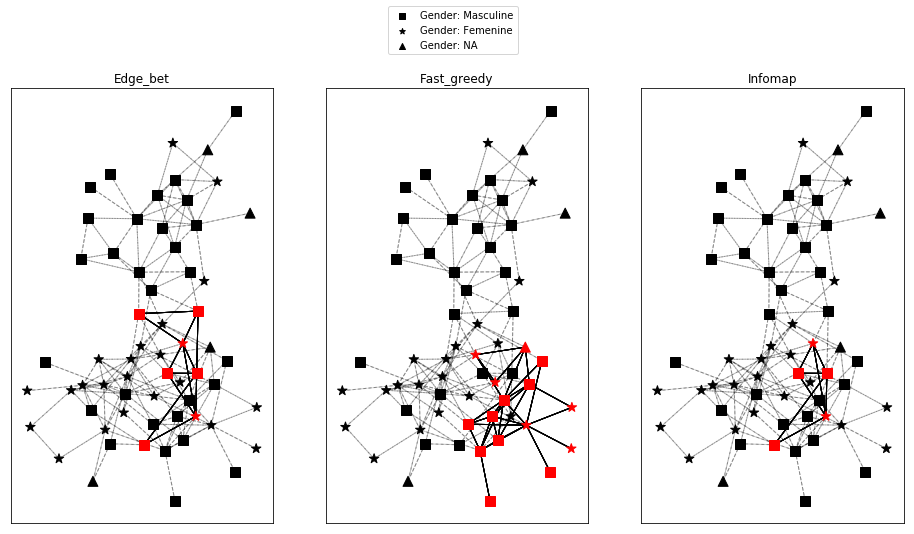

In [122]:
f, axs = plt.subplots(1, 3, figsize=(16,8))
axs = axs.flatten()

metodos = [item[0] for item in comunidades_proporcionadas]

for i,metodo in enumerate(metodos):
    particion = particiones[metodo]
    comunidad_de_interes = [item[1] for item in comunidades_proporcionadas if item[0] == metodo][0]

    node_color_dict = {}
    edge_list_comunidad = []
    edge_list_resto = []
    for node in Red_delfines.nodes():
        if particion[node] == comunidad_de_interes:
            node_color_dict[node] = 'red'
            for edge in Red_delfines.edges(node):
                if edge[1] in delfines_por_comunidad[metodo][comunidad_de_interes]:
                    edge_list_comunidad.append(edge)
                else: 
                    edge_list_resto.append(edge)
        else:
            node_color_dict[node] = 'black'
            edge_list_resto.extend(list(Red_delfines.edges(node)))
            
    for aShape in shapes: 
        
        node_list = [sNode for sNode, attr in Red_delfines.nodes(data = True) if attr['shape'] == aShape]
        node_color = [node_color_dict[sNode] for sNode in node_list]
        nx.draw_networkx_edges(Red_delfines, posiciones, edgelist = list(edge_list_comunidad), alpha = 1., ax = axs[i])
        nx.draw_networkx_edges(Red_delfines, posiciones, edgelist = edge_list_resto, alpha = 0.1, ax = axs[i], style = 'dashed')
        nx.draw_networkx_nodes(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
    
    axs[i].set_title(metodo)
    
    label = {'s': 'Masculine', '*':'Femenine', '^':"NA"}
for aShape in shapes:
    plt.scatter([],[], c = 'black', marker = aShape, label='Gender: {}'.format(label[aShape]))

plt.legend(bbox_to_anchor=(-0.45, 1.2))
plt.show()